<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 

<a href="http://www.math.univ-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo_imt.jpg" style="float:right; max-width: 250px; display: inline" alt="IMT"/> </a>
</center>

## Chatbot: catégorisations et prévisions des réponses aux questions

# Text Mining et Catégorisation de Produits en <a href="https://www.python.org/"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Python_logo_and_wordmark.svg/390px-Python_logo_and_wordmark.svg.png" style="max-width: 120px; display: inline" alt="R"/></a> avec <a href="http://scikit-learn.org/stable/#"><img src="http://scikit-learn.org/stable/_static/scikit-learn-logo-small.png" style="max-width: 100px; display: inline" alt="R"/></a>

## Introduction

Il s'agit de prévoir la réponse à une question à partir de son sujet. Seule la catégorie principale (1er niveau) est prédite mais nous pourrons essayer d'affiner par la suite. L'objectif est plutôt de comparer les performances des méthodes et technologies en fonction de la taille de la base d'apprentissage ainsi que d'illustrer sur un exemple complexe le prétraitement de données textuelles. La stratégie de sous ou sur échantillonnage des catégories qui permet d'améliorer la prévision va être mise en oeuvre. Nous allons essayer différentes techniques d'échantillonnage comme le regroupement de plusieurs catégories en fonction de leur points communs ou selon leur taille puis nous essayerons de mettre en place un mélange de upsampling et de downsampling.
* Nous allons réduire l'échantillon réduit en le séparant en 2 parties: apprentissage et validation. 
* Les données textuelles sont  nettoyées, racinisées, vectorisées avant modélisation.
* Trois modélisations sont estimées: logistique, arbre, forêt aléatoire.
* Optimiser l'erreur en faisant varier différents paramètres: types et paramètres de vectorisation (TF-IDF), paramètres de la régression logistique (pénalisation l1) et de la forêt aléatoire (nombre d'arbres et nombre de variables aléatoire).

Exécuter finalement le code pour différentes tailles (paramètre  `tauxTot` ci-dessous) de l'échantillon d'apprentissage et comparer les qualités de prévision obtenues. 

In [1]:
#Importation des librairies utilisées
import unicodedata 
import time
import pandas as pd
import numpy as np
import random
import nltk
import collections
import itertools
import csv
import warnings

from sklearn.cross_validation import train_test_split

C:\Users\emma\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

## 1. Importation des données
Définition du répertoir de travail, des noms des différents fichiers utilisés et des variables globales.


In [3]:
# Répertoire de travail
DATA_DIR = "C:\Users\emma\Documents\ecole\insa\projet chabot\INSA_wefight_data_clean.csv"

# Nom des fichiers
training_reduit_path = DATA_DIR 
# Variable Globale
HEADER_TEST = ['Question','Intent','BlockId', 'Action']
HEADER_TRAIN =['Question','Intent','BlockId', 'Action']

In [4]:
## Si nécessaire (première exécution) chargement de nltk, librairie pour la suppression 
## des mots d'arrêt et la racinisation
## nltk.download()

   ### Read & Split Dataset
   Fonction permettant de lire le fichier d'apprentissage et de créer deux DataFrame Pandas, un pour l'apprentissage, l'autre pour la validation.
   La première méthode créée un DataFrame en lisant entièrement le fichier. Puis elle scinde le DataFrame en deux  grâce à la fonction dédiée de sklearn. 

In [5]:
def split_dataset(input_path, nb_line, tauxValid,columns):
    time_start = time.time()
    data_all = pd.read_csv(input_path,sep=",",names=columns,nrows=nb_line) #cree data frame
    data_all = data_all.fillna("") #remplace les na par " "
    data_train, data_valid = train_test_split(data_all, test_size = tauxValid) # Split arrays or matrices into random train and test subsets
    time_end = time.time()
    print("Split Takes %d s" %(time_end-time_start))
    return data_train, data_valid

nb_line=20000  # part totale extraite du fichier initial ici déjà réduit
tauxValid=0.10 # part totale extraite du fichier initial ici déjà réduit
data_train, data_valid = split_dataset(training_reduit_path, nb_line, tauxValid, HEADER_TRAIN)
data_all = pd.read_csv(training_reduit_path,sep=",",names=HEADER_TRAIN,nrows=nb_line) #cree data frame
# Cette ligne permet de visualiser les 5 premières lignes de la DataFrame 
data_train.head(5)

Split Takes 0 s


,Question,Intent,BlockId,Action
1864,est-ce que je peux dormir en journée,#2-72_QVDP_Fatigue_Sieste,59846316e4b03f0d141962b2,wiki_cancer
1544,j'ai des contractures,#2-55_QVDP_Douleur,59843bb8e4b03f0d1304835d,wiki_cancer
1955,quels sont les programmes de sport,#2-79_QVDP_SportQuel,59895d38e4b03f0d2cdd37b1,wiki_cancer
644,une baisse de l'érection,#2-126_QVDP_Sexualite_BaisseLibido,59918af3e4b0feb28874407c,wiki_cancer
2807,Qu'est ce que c'est que la pressothérapie,#6-40_TRTEINS_PressotherapieLymphodeme,598b50f2e4b03f0d37184ae0,wiki_cancer


## 2. Nettoyage des données
Afin de limiter la dimension de l'espace des variables ou *features*, tout en conservant les informations essentielles, il est nécessaire de nettoyer les données en appliquant plusieurs étapes:
* Chaque mot est écrit en minuscule.
* Les termes numériques, de ponctuation et autres symboles sont supprimés.
* 155 mots-courants, et donc non informatifs, de la langue française sont supprimés (STOPWORDS). Ex: le, la, du, alors, etc...
* Chaque mot est "racinisé", via la fonction `STEMMER.stem` de la librairie nltk. La racinisation transforme un mot en son radical ou sa racine. Par exemple, les mots: cheval, chevaux, chevalier, chevalerie, chevaucher sont tous remplacés par "cheva".

### Importation des librairies et fichier pour le nettoyage des données.

In [6]:
# Librairies 
from bs4 import BeautifulSoup #Nettoyage d'HTML
import re # Regex
import nltk # Nettoyage des données

## listes de mots à supprimer dans la description des produits
## Depuis NLTK
nltk_stopwords = nltk.corpus.stopwords.words('french') 
## Depuis Un fichier externe.
lucene_stopwords = [unicode(w, "utf-8") for w in open("C:\Users\emma\Documents\ecole\insa\projet chabot\lucene_stopwords.txt").read().split(",")] #En local

## Union des deux fichiers de stopwords 
stopwords = list(set(nltk_stopwords).union(set(lucene_stopwords)))

## Fonction de setmming de stemming permettant la racinisation
stemmer=nltk.stem.SnowballStemmer('french')

### Fonction de nettoyage de texte
Fonction qui prend en intrée un texte et retourne le texte nettoyé en appliquant successivement les étapes suivantes: Nettoyage des données HTML, conversion en texte minuscule, encodage uniforme, suppression des caractéres non alpha numérique (ponctuations), suppression des stopwords, racinisation de chaque mot individuellement.

In [20]:
# Fonction clean générale
def clean_txt(txt):
    ### remove html stuff
    txt = BeautifulSoup(txt,"html.parser",from_encoding='utf-8').get_text() #nettoyage donnee html
    ### lower case
    txt = txt.lower()
    ### special escaping character '...'
    txt = txt.replace(u'\u2026','.')
    txt = txt.replace(u'\u00a0',' ')
    ### remove accent btw
    txt = unicodedata.normalize('NFD', txt).encode('ascii', 'ignore')
    ###txt = unidecode(txt)
    ### remove non alphanumeric char
    txt = re.sub('[^a-z_]', ' ', txt)
    ###stemming sur stopwords
    stopwords2=[stemmer.stem(stop) for stop in stopwords]
    ### remove french stop words
    tokens = [w for w in txt.split() if (len(w)>2) and (w not in stopwords)]
    ### french stemming
    tokens = [stemmer.stem(token) for token in tokens]
    #Stemmers remove morphological affixes from words, leaving only the word stem
    ### tokens = stemmer.stemWords(tokens)
    tokens= [w for w in tokens if (len(w)>2) and (w not in stopwords2)]
    return ' '.join(tokens)
    #join() returns a string in which the string elements of sequence have been joined by str separator.

def clean_marque(txt):
    txt = re.sub('[^a-zA-Z0-9]', '_', txt).lower()
    return txt

### Nettoyage des DataFrames
Applique le nettoyage sur toutes les lignes de la DataFrame

In [21]:
# fonction de nettoyage du fichier(stemming et liste de mots à supprimer)
def clean_df(input_data, column_names= ['Question','Intent','BlockId', 'Action']):
    #Test if columns entry match columns names of input data
    column_names_diff= set(column_names).difference(set(input_data.columns))
    #set.difference   new set with elements in column_names but not in input_data.columns
    
    if column_names_diff: #rentre dans la boucle si column_names différent zero
        # warning = exception
        warnings.warn("Column(s) '"+", ".join(list(column_names_diff)) +"' do(es) not match columns of input data", Warning)
        
    nb_line = input_data.shape[0]
    print("Start Clean %d lines" %nb_line)
    
    # Cleaning start for each columns
    time_start = time.time()
    clean_list=[]
    for column_name in column_names:
        column = input_data[column_name].values
        if column_name == "Question":
            array_clean = np.array(map(clean_txt,column))
            
        elif column_name == "Intent":
            array_clean = np.asarray(input_data['Intent']) #on recopie telle quelle la colonne intent  
            
        else:
            array_clean = np.array(map(clean_marque,column))
            #applies a function to all the items in an input_list
            #map(function_to_apply, list_of_inputs)
        clean_list.append(array_clean)
    time_end = time.time()
    print("Cleaning time: %d secondes"%(time_end-time_start))
    
    #Convert list to DataFrame
    array_clean = np.array(clean_list).T
    data_clean = pd.DataFrame(array_clean, columns = column_names)
    return data_clean

In [22]:
# Take approximately 2 minutes fors 100.000 rows
data_valid_clean = clean_df(data_valid)
data_train_clean = clean_df(data_train)
#data_all_clean= clean_df(data_all)

Start Clean 502 lines
Cleaning time: 17 secondes
Start Clean 4511 lines
Cleaning time: 142 secondes


Affiche les 5 premières lignes de la DataFrame d'apprentissage après nettoyage.

In [23]:
#info sur les données
data_train_clean.info()
data_train_clean.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4511 entries, 0 to 4510
Data columns (total 4 columns):
Question    4511 non-null object
Intent      4511 non-null object
BlockId     4511 non-null object
Action      4511 non-null object
dtypes: object(4)
memory usage: 141.0+ KB


,Question,Intent,BlockId,Action
0,peux dorm journe,#2-72_QVDP_Fatigue_Sieste,59846316e4b03f0d141962b2,wiki_cancer
1,contractur,#2-55_QVDP_Douleur,59843bb8e4b03f0d1304835d,wiki_cancer
2,programm sport,#2-79_QVDP_SportQuel,59895d38e4b03f0d2cdd37b1,wiki_cancer
3,baiss erect,#2-126_QVDP_Sexualite_BaisseLibido,59918af3e4b0feb28874407c,wiki_cancer
4,pressotherap,#6-40_TRTEINS_PressotherapieLymphodeme,598b50f2e4b03f0d37184ae0,wiki_cancer


In [24]:
# comptage du nbre d'occurence de categorie puis comptage du nbre de categorie differente
print(data_train["Action"].value_counts())
print("nb Action differente",(data_train["Action"].value_counts()).shape)

wiki_cancer                                          4245
conversation_rappelRendezVous                          81
                                                       80
conversation_rappelRead                                33
conversation_rappelUpdate2                             16
wiki_cancer#                                           14
conversation_FichePatientRead                           9
conversation_FichePatientUpdate                         7
conversation_hist                                       5
conversation_FichePatientWrite:age                      4
conversation_FichePatientWrite:doseTraitement           3
conversation_FichePatientWrite:newsletter               2
conversation_FichePatientWrite:typeTraitement           2
conversation_rappelUpdate                               2
conversation_FichePatientWrite:rappels                  2
conversation_FichePatientWrite:partagerTemoignage       1
conversation_FichePatientWrite:recevoirTemoignage       1
conversation_F

In [25]:
# comptage u nbre d'occurence de categorie puis comptage du nbre de categorie differente
print(data_train["Intent"].value_counts())
print("nb intent differente",(data_train["Intent"].value_counts()).shape)

#6-49_TRTEINS_Peau                               200
#6-97_TRTEINS_Nausees_Vomissements               129
#6-92_TRTEINS_Diarrhee                           128
#2-130_QVDP_Alimentation                         121
#6-53_TRTEINS_Aphtes                             116
#6-90_TRTEINS_Mauvais_Gout                       107
#2-36_QVDP_Alopecie_Pourquoi                      99
#6-98_TRTEINS_EI_Frequents                        98
#9-2_Informations_cancer                          95
#6-60_TRTEINS_PAC                                 94
#6-18_TRTEINS_Radiotherapie                       83
#2-55_QVDP_Douleur                                82
#6-57_TRTEINS_Yeux_Secs                           81
#2-64-0_QVDP_Fatigue                              81
conversation_rappel_rendezvous                    81
#6-96_TRTEINS_Perte_Poids                         77
#2-96_QVDP_Social_Priseencharge                   72
#6-1_TRTEINS_Chimiotherapie                       72
#2-45_QVDP_Alopecie_Perruque                  

In [26]:
#on enregistre le contenu de la colonne Question dans un fichier csv
#on fait ensuite un wordcloud sur toutes les donnees
description = data_train_clean["Question"]
description.to_csv('Question.csv', sep = ',')

In [27]:
# tri par catégorie, on a un data frame pour une catégorie
df = data_train_clean[data_train_clean['Intent'] == "#6-49_TRTEINS_Peau"]
df.head()

,Question,Intent,BlockId,Action
32,douch bain,#6-49_TRTEINS_Peau,59918cf1e4b0feb28881fd9f,wiki_cancer
83,erupt cutane normal,#6-49_TRTEINS_Peau,59918cf1e4b0feb28881fd9f,wiki_cancer
94,evit secheress cutane,#6-49_TRTEINS_Peau,59918cf1e4b0feb28881fd9f,wiki_cancer
125,savon peut utilis,#6-49_TRTEINS_Peau,59918cf1e4b0feb28881fd9f,wiki_cancer
132,peau irrite,#6-49_TRTEINS_Peau,59918cf1e4b0feb28881fd9f,wiki_cancer


# 3. Création méta-catégories

In [28]:
#meta classe

categories = data_train_clean['Intent']
#categories = data_all['Intent']
tailleCat = int(np.shape(categories)[0])
LabelCat = np.zeros(tailleCat)
for k in range(tailleCat):
    # la categorie #0 a le label 0 implicitement
    if categories[k][0:2]=='Pr':  LabelCat[k] = 11#profile
    if (categories[k][0:2] == 'co' or categories[k][0:2]=='Co'): LabelCat[k] = 10 #conversation_rappel_rendezvous
    if categories[k][0:2] == '#1' : LabelCat[k] = 1
    if categories[k][0:2] == '#2' : LabelCat[k] = 2
    if categories[k][0:2] == '#3' : LabelCat[k] = 3 ##il y a personne dedans 
    if categories[k][0:2] == '#4' : LabelCat[k] = 4  ## il y a personne dedans
    if categories[k][0:2] == '#5' : LabelCat[k] = 5
    if categories[k][0:2] == '#6' : LabelCat[k] = 6
    if categories[k][0:2] == '#7' : LabelCat[k] = 7
    if categories[k][0:2] == '#8' : LabelCat[k] = 8
    if categories[k][0:2] == '#9' : LabelCat[k] = 9

In [29]:
#data frame avec une colonne mettant un label suivant la meta categorie
dfLabelCat = pd.DataFrame(LabelCat)
meta_df = pd.concat([data_train_clean, dfLabelCat], axis=1)
meta_df.head()

,Question,Intent,BlockId,Action,0
0,peux dorm journe,#2-72_QVDP_Fatigue_Sieste,59846316e4b03f0d141962b2,wiki_cancer,2.0
1,contractur,#2-55_QVDP_Douleur,59843bb8e4b03f0d1304835d,wiki_cancer,2.0
2,programm sport,#2-79_QVDP_SportQuel,59895d38e4b03f0d2cdd37b1,wiki_cancer,2.0
3,baiss erect,#2-126_QVDP_Sexualite_BaisseLibido,59918af3e4b0feb28874407c,wiki_cancer,2.0
4,pressotherap,#6-40_TRTEINS_PressotherapieLymphodeme,598b50f2e4b03f0d37184ae0,wiki_cancer,6.0


In [30]:
#on stocke les questions pour chaque cle, chaque cle sera une categorie
dix = []
neuf = []
huit = []
sept = []
six = []
cinq = []
quatre = []
trois = []
deux = []
un = []
zero = []
onze = []
for k in range(tailleCat):
    if meta_df[0][k] == 10.0 : dix.append(meta_df['Question'][k])
    if meta_df[0] [k] == 9.0 : neuf.append (meta_df['Question'][k])
    if meta_df[0][k] == 8.0 : huit.append (meta_df['Question'][k])
    if meta_df[0][k] == 7.0 : sept.append (meta_df['Question'][k])
    if meta_df[0][k] == 6.0 : six.append (meta_df['Question'][k])
    if meta_df[0][k] == 5.0 : cinq.append (meta_df['Question'][k])
    if meta_df[0][k] == 4.0 : quatre.append(meta_df['Question'][k])
    if meta_df[0][k] == 3.0 : trois.append (meta_df['Question'][k])
    if meta_df[0][k] == 2.0 : deux.append (meta_df['Question'][k])
    if meta_df[0][k] == 1.0 : un.append (meta_df['Question'][k])
    if meta_df[0][k] == 0.0 : zero.append (meta_df['Question'][k])
    if meta_df[0][k] == 11.0 : onze.append (meta_df['Question'][k])    
label = range(12)
questionLab = [zero,un,deux,trois,quatre,cinq,six,sept,huit,neuf,dix,onze]

meta_dict = dict(zip(label,questionLab)) # creation du dictionnaire

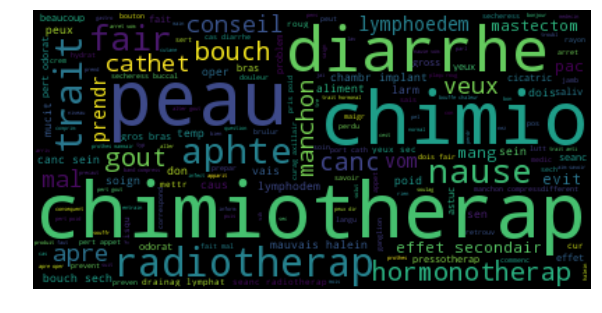

In [31]:
from os import path
from wordcloud import WordCloud

# tri par catégorie, on a un data frame pour une méta catégorie
df = meta_df['Question'][meta_df[0] == 6.0]#traitements
df.to_csv('Question.csv', sep = ',')
text = open("C:\Users\emma\Documents\ecole\insa\projet chabot\Question.csv").read()
# Generate a word cloud image
wordcloud = WordCloud().generate(text)

wordcloud = WordCloud(max_font_size=60).generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


ci dessus le wordcloud sur la meta categ 6 : traitement. On retiendra comme stopwords pour cette catgéorie les mots suivants: chimiothérapie, nausée, peau et diarhée. 

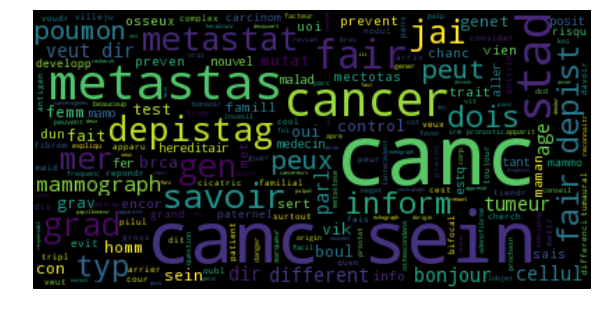

In [32]:
# tri par catégorie, on a un data frame pour une méta catégorie
df = meta_df['Question'][meta_df[0] == 9.0]#information

description3 = df
description3.to_csv('Question.csv', sep = ',')
text = open("C:\Users\emma\Documents\ecole\insa\projet chabot\Question.csv").read()
# Generate a word cloud image
wordcloud = WordCloud().generate(text)

wordcloud = WordCloud(max_font_size=60).generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


On retiendra comme stopwords pour la catégorie information les mots suivants: cancer, sein et metastase 

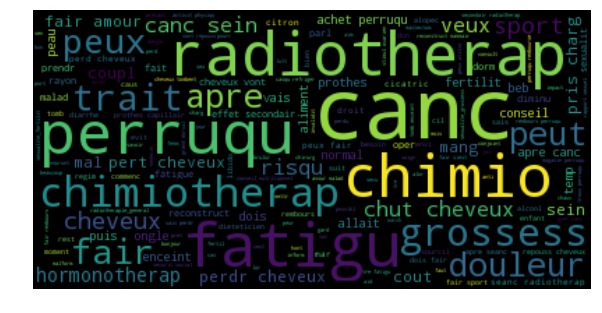

In [33]:
from os import path
from wordcloud import WordCloud

# tri par catégorie, on a un data frame pour une méta catégorie
df = meta_df['Question'][meta_df[0] == 2.0]#qvdp
df.to_csv('Question.csv', sep = ',')
text = open("C:\Users\emma\Documents\ecole\insa\projet chabot\Question.csv").read()
# Generate a word cloud image
wordcloud = WordCloud().generate(text)

wordcloud = WordCloud(max_font_size=60).generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

On retiendra comme stopwords pour la catégorie qvdp les mots suivants: chimiothérapie, cancer,radiothérapie, fatigue et perruque

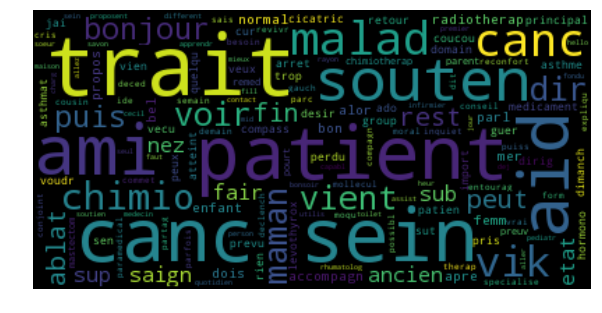

In [34]:
from os import path
from wordcloud import WordCloud

# tri par catégorie, on a un data frame pour une méta catégorie
df = meta_df['Question'][meta_df[0] == 1.0]#menu
df.to_csv('Question.csv', sep = ',')
text = open("C:\Users\emma\Documents\ecole\insa\projet chabot\Question.csv").read()
# Generate a word cloud image
wordcloud = WordCloud().generate(text)

wordcloud = WordCloud(max_font_size=60).generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

On retiendra comme stopwords pour la catégorie menu les mots suivants: ami, traitement, patient, cancer et sein

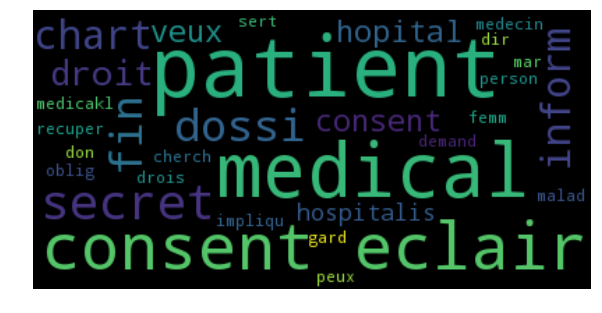

In [35]:
from os import path
from wordcloud import WordCloud

# tri par catégorie, on a un data frame pour une méta catégorie
df = meta_df['Question'][meta_df[0] == 8.0]#ddp
df.to_csv('Question.csv', sep = ',')
text = open("C:\Users\emma\Documents\ecole\insa\projet chabot\Question.csv").read()
# Generate a word cloud image
wordcloud = WordCloud().generate(text)

wordcloud = WordCloud(max_font_size=60).generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

On retiendra comme stopwords pour la catégorie ddp les mots suivants: patient, medical, fin et consentement

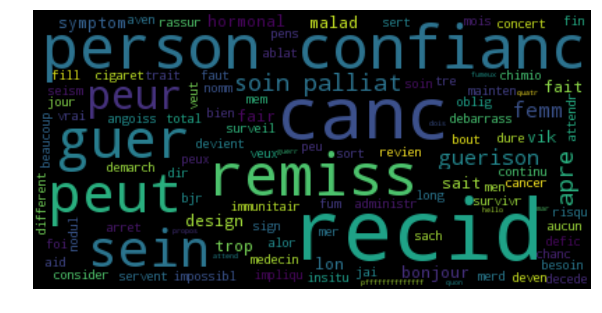

In [36]:
# tri par catégorie, on a un data frame pour une méta catégorie
df = meta_df['Question'][meta_df[0] == 7.0]#qvda remission recidive

description3 = df
description3.to_csv('Question.csv', sep = ',')
text = open("C:\Users\emma\Documents\ecole\insa\projet chabot\Question.csv").read()
# Generate a word cloud image
wordcloud = WordCloud().generate(text)

wordcloud = WordCloud(max_font_size=60).generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

On retiendra comme stopwords pour la catégorie qvda remission récidive les mots suivants: rémission, récidive, cancer et peut (pouvoir).

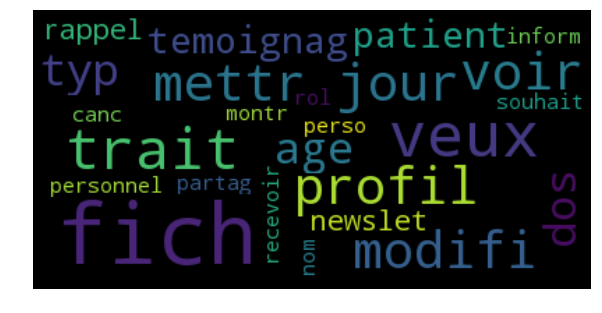

In [37]:
# tri par catégorie, on a un data frame pour une méta catégorie
df = meta_df['Question'][meta_df[0] == 11.0]#profile

description3 = df
description3.to_csv('Question.csv', sep = ',')
text = open("C:\Users\emma\Documents\ecole\insa\projet chabot\Question.csv").read()
# Generate a word cloud image
wordcloud = WordCloud().generate(text)

wordcloud = WordCloud(max_font_size=60).generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

On retiendra comme stopwords pour la catégorie profile les mots suivants: fiche, profil et veux.

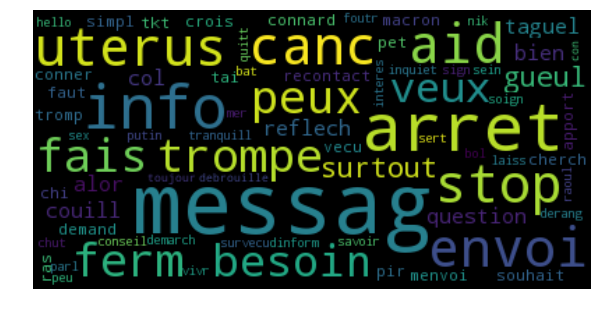

In [38]:
# tri par catégorie, on a un data frame pour une méta catégorie
df = meta_df['Question'][meta_df[0] == 0.0]#gestion

description3 = df
description3.to_csv('Question.csv', sep = ',')
text = open("C:\Users\emma\Documents\ecole\insa\projet chabot\Question.csv").read()
# Generate a word cloud image
wordcloud = WordCloud().generate(text)

wordcloud = WordCloud(max_font_size=60).generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

On retiendra comme stopwords pour la catégorie gestion les mots suivants: message, cancer, information et besoin.

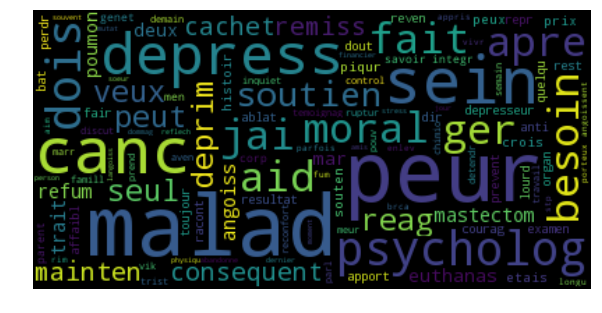

In [39]:
# tri par catégorie, on a un data frame pour une méta catégorie
df = meta_df['Question'][meta_df[0] == 5.0]#soutien

description3 = df
description3.to_csv('Question.csv', sep = ',')
text = open("C:\Users\emma\Documents\ecole\insa\projet chabot\Question.csv").read()
# Generate a word cloud image
wordcloud = WordCloud().generate(text)

wordcloud = WordCloud(max_font_size=60).generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

On retiendra comme stopwords pour la catégorie soutien les mots suivants: malade, dépression, peur et cancer.

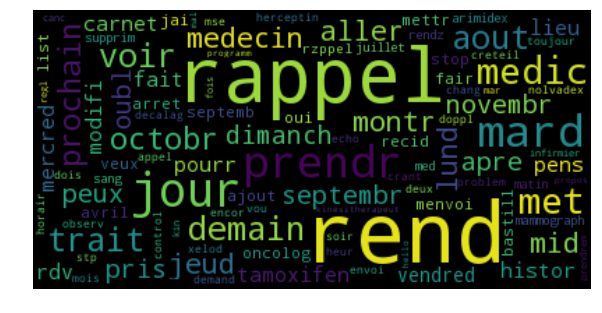

In [40]:
# tri par catégorie, on a un data frame pour une méta catégorie
df = meta_df['Question'][meta_df[0] == 10.0]#conversation

description3 = df
description3.to_csv('Question.csv', sep = ',')
text = open("C:\Users\emma\Documents\ecole\insa\projet chabot\Question.csv").read()
# Generate a word cloud image
wordcloud = WordCloud().generate(text)

wordcloud = WordCloud(max_font_size=60).generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

On retiendra comme stopwords pour la catégorie conversation les mots suivants: rappel, prendre et voir.

In [41]:
meta = meta_df[0] # meta catégorie

color_seq = [] #liste de couleurs

#on associe à chaque individu une couleur en fonction de sa classe
for k in range(int(np.shape(meta_df['Question'])[0])):
    if meta[k] == 1.0 : color_seq.append("black")
    elif meta[k] == 2.0: color_seq.append("red")
    elif meta[k] == 3.0: color_seq.append("green")
    elif meta[k] == 4.0: color_seq.append("yellow")
    elif meta[k] == 5.0: color_seq.append("fuchsia")
    elif meta[k] == 6.0: color_seq.append("aqua")
    elif meta[k] == 7.0: color_seq.append("brown")
    elif meta[k] == 8.0: color_seq.append("indigo")
    elif meta[k] == 9.0: color_seq.append("lightblue")
    else : color_seq.append("blue")

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.feature_extraction import FeatureHasher

stop_words = nltk.corpus.stopwords.words('french')
question = meta_df["Question"] #on va travailler que sur la colonne des questions
vec = TfidfVectorizer(
            min_df = 1, #on prend tous les mots
            stop_words =stop_words,
            smooth_idf=True,
            norm='l2',
            sublinear_tf=True,
            use_idf=True, #tf avec idf
            ngram_range=(1,1)) # BIEN REFLECHIR COMMENT L UTILISER
tfidf =  vec.fit_transform(question)
# définition de la commande
X = tfidf
nom = vec.get_feature_names() #on recupere le nom des variables
svd = TruncatedSVD(n_components=30, n_iter=40, random_state=42)
svd.fit(X)
#variance expliquee
print(svd.explained_variance_ratio_) 
print (" ")
#valeurs singuliere
print(svd.singular_values_)
C = svd.fit(X).transform(X)


[0.01457317 0.01159332 0.01230131 0.01067256 0.00961871 0.00953534
 0.0094737  0.00889539 0.00852394 0.00854064 0.00807563 0.00767667
 0.00717876 0.00701133 0.0069465  0.00660042 0.00638528 0.0060522
 0.00593224 0.00570898 0.00566664 0.00545804 0.00541447 0.00534225
 0.00527909 0.00507164 0.00496616 0.00494293 0.00489222 0.00474232]
 
[9.34228219 7.84692184 7.42707329 6.90541247 6.69659111 6.55606318
 6.50412081 6.31377022 6.19242241 6.17935869 6.04035341 5.84939671
 5.6684955  5.63948763 5.56945545 5.43187813 5.35789204 5.24976327
 5.14150861 5.07121248 5.04111122 4.94150839 4.92011046 4.87880053
 4.85201216 4.75338579 4.70467699 4.69878572 4.66871251 4.59808812]


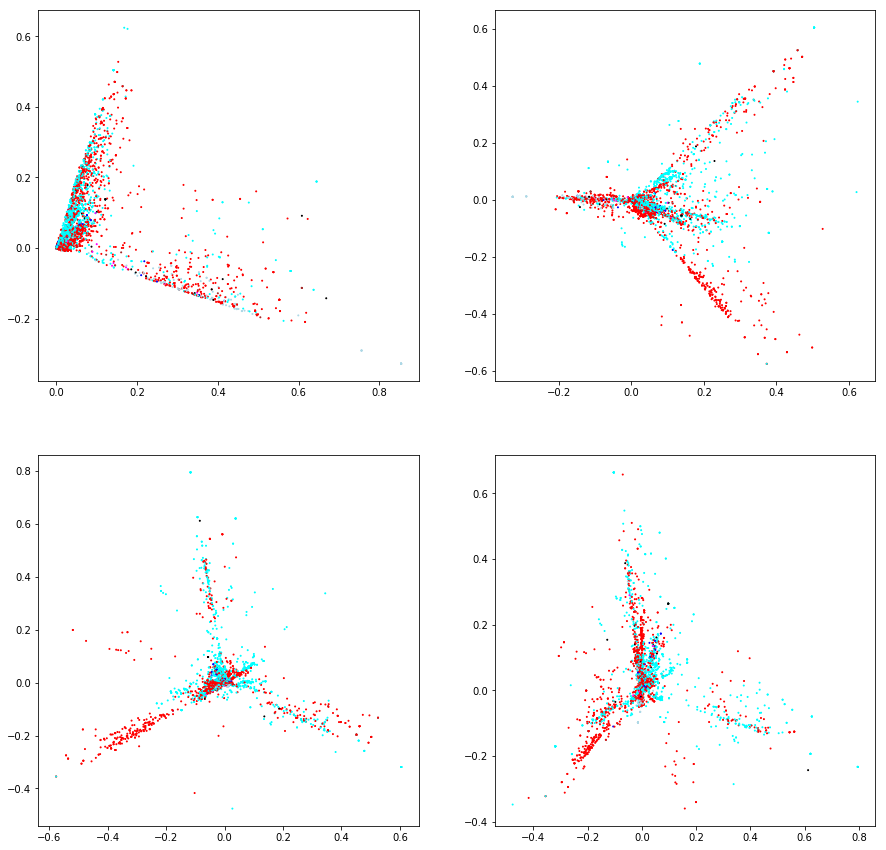

In [43]:
fig = plt.figure(figsize=(15,15))
# premier plan factoriel
ax = fig.add_subplot(2,2,1)
ax.scatter(C[:,0], C[:,1], s=1,c = color_seq)

# deuxieme plan factoriel
ax = fig.add_subplot(2,2,2)
ax.scatter(C[:,1], C[:,2], s=1,c = color_seq)

# troisieme plan factoriel
ax = fig.add_subplot(2, 2, 3)
ax.scatter(C[:,2], C[:,3], s=1,c = color_seq)

# quatrieme plan factoriel
ax = fig.add_subplot(2, 2, 4)
ax.scatter(C[:,3], C[:,4], s=1,c = color_seq)
plt.show()

en bleu clair : la meta categ traitement 
    en rouge : QVDP
        les autres on les voit pas : dans la suite visualisons sans les deux categ les + fournies

In [44]:
color_seq= [] #liste de couleurs

#on associe à chaque individu une couleur en fonction de sa classe
for k in range(int(np.shape(meta_df['Question'])[0])):
    if meta[k] == 1.0 : color_seq.append("black")
    elif meta[k] == 2.0: color_seq.append("None")
    elif meta[k] == 3.0: color_seq.append("green")
    elif meta[k] == 4.0: color_seq.append("yellow")
    elif meta[k] == 5.0: color_seq.append("fuchsia")
    elif meta[k] == 6.0: color_seq.append("None")
    elif meta[k] == 7.0: color_seq.append("brown")
    elif meta[k] == 8.0: color_seq.append("indigo")
    elif meta[k] == 9.0: color_seq.append("lightblue")
    else : color_seq.append("blue")

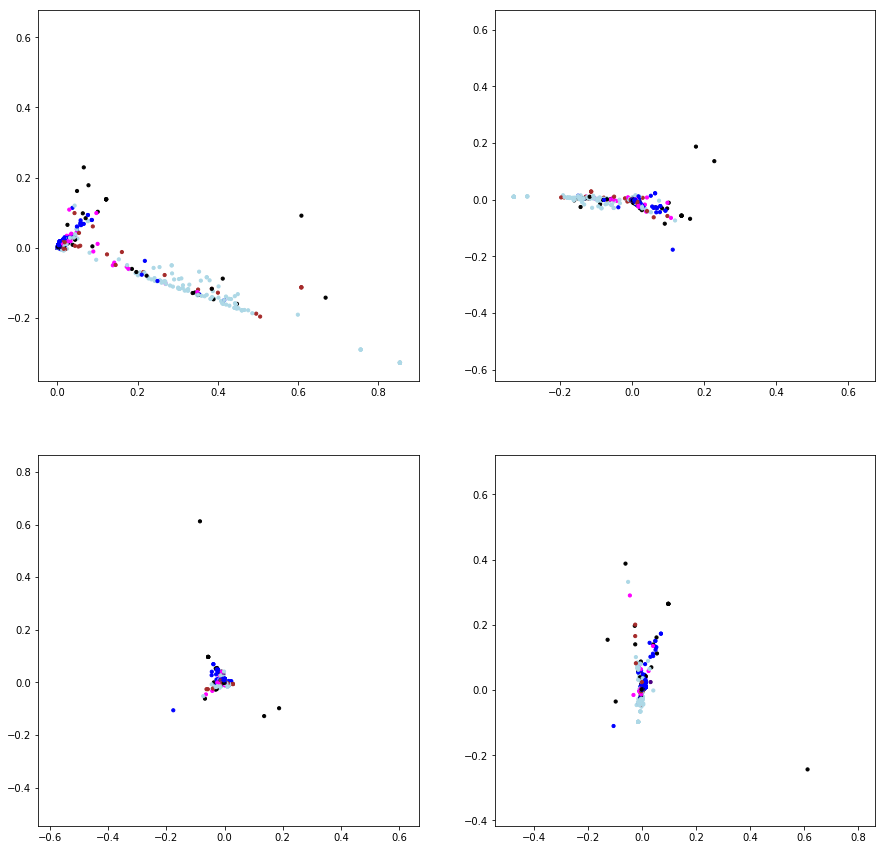

In [45]:
fig = plt.figure(figsize=(15,15))
# premier plan factoriel
ax = fig.add_subplot(2,2,1)
ax.scatter(C[:,0], C[:,1], s=10,c = color_seq)

# deuxieme plan factoriel
ax = fig.add_subplot(2,2,2)
ax.scatter(C[:,1], C[:,2], s=10,c = color_seq)

# troisieme plan factoriel
ax = fig.add_subplot(2, 2, 3)
ax.scatter(C[:,2], C[:,3], s=10,c = color_seq)

# quatrieme plan factoriel
ax = fig.add_subplot(2, 2, 4)
ax.scatter(C[:,3], C[:,4], s=10,c = color_seq)
plt.show()

sur le 1er plan on voit un axe qui détermine très bien la meta categ 9 caractérisée donc par "sein" et "cancer"

### Essayons maintenant d'affiner notre classification avec l'ajout de stopwords en fonction des méta catégories

Nous avons 10 méta-catégories et 146 sous catégories. Nous allons effectuer des wordcloud pour chaque méta-catégorie. Avec ces wordcloud nous essayerons de repérer les 3-4 mots les plus représentatifs de la méta-catégorie. Ces mots sont par définition présents dans les sous catégories de la méta-catégorie. Nous allons donc rajouter ces mots aux stopwords afin d'affiner notre discrimination envers les sous catégories.

In [46]:
#Création base de données non nettoyées
categories = data_all['Intent']
tailleCat = int(np.shape(categories)[0])
LabelCat = np.zeros(tailleCat)
for k in range(tailleCat):
    # la categorie #0 a le label 0 implicitement
    if categories[k][0:2]=='Pr':  LabelCat[k] = 11#profile
    if (categories[k][0:2] == 'co' or categories[k][0:2]=='Co'): LabelCat[k] = 10 #conversation_rappel_rendezvous
    if categories[k][0:2] == '#1' : LabelCat[k] = 1
    if categories[k][0:2] == '#2' : LabelCat[k] = 2
    if categories[k][0:2] == '#5' : LabelCat[k] = 5
    if categories[k][0:2] == '#6' : LabelCat[k] = 6
    if categories[k][0:2] == '#7' : LabelCat[k] = 7
    if categories[k][0:2] == '#8' : LabelCat[k] = 8
    if categories[k][0:2] == '#9' : LabelCat[k] = 9

#data frame avec une colonne mettant un label suivant la meta categorie
dfLabelCat = pd.DataFrame(LabelCat)
data_all2=data_all.drop(data_all.index[0])
meta_df = pd.concat([data_all, dfLabelCat], axis=1)
meta_df1= meta_df.drop(meta_df.index[0])
meta_df1.head()


,Question,Intent,BlockId,Action,0
1,Quelles sont les signes du cancer de l'utérus,#000_Menu_General,59e5f626e4b0662e79d70343,wiki_cancer,0.0
2,En savoir plus 🔎,#000_Menu_General,59e5f626e4b0662e79d70343,wiki_cancer,0.0
3,Comment peux tu m aider par apport à ma question,#000_Menu_General,59e5f626e4b0662e79d70343,wiki_cancer,0.0
4,+ infos,#000_Menu_General,59e5f626e4b0662e79d70343,wiki_cancer,0.0
5,Je me suis tromper,#000_Menu_General,59e5f626e4b0662e79d70343,wiki_cancer,0.0


Nous voulons nettoyer les données différemment selon leur méta catégorie pour ensuite avoir une meilleure discrimination des sous catégories

In [102]:
meta_df11=meta_df1[meta_df1[0]==6.0]
stopwords_perso = ["chimiotherapie", "peau", "nausee", "diarrhee"]

In [103]:
#for k in range(5012):
 #       if meta_df1[0][k] == 10.0 : stopwords_perso = ["rappel", "prendre", "voir"]
  #      if meta_df1[0] [k] == 9.0 : stopwords_perso = ["cancer", "sein", "metastase"]
   #     if meta_df1[0][k] == 8.0 : stopwords_perso = ["patient", "medical", "fin"]
    #    if meta_df1[0][k] == 7.0 : stopwords_perso = ["remission", "recidive", "cancer", "peut"]
     #   if meta_df1[0][k] == 6.0 : stopwords_perso = ["chimiotherapie", "peau", "nausee", "diarrhee"]
      #  if meta_df1[0][k] == 5.0 : stopwords_perso = ["depression", "peur", "cancer"]
       # if meta_df1[0][k] == 11.0 : stopwords_perso = ["fiche", "profil", "veux"]
        #if meta_df1[0][k] == 2.0 : stopwords_perso = ["chimiotheapie", "radiotherapie", "cancer", "fatigue", "perruque"]
      #  if meta_df1[0][k] == 1.0 : stopwords_perso = ["ami", "traitement", "patient"]
      #  if meta_df1[0][k] == 0.0 : stopwords_perso = ["message", "information", "besoin", "cancer"]

In [104]:
## Fonction de setmming permettant la racinisation
stemmer=nltk.stem.SnowballStemmer('french')
stopwords2 = list(set(stopwords).union(set(stopwords_perso)))

# Fonction clean générale
def clean_txt2(txt):
    ### remove html stuff
    txt = BeautifulSoup(txt,"html.parser",from_encoding='utf-8').get_text() #nettoyage donnee html
    ### lower case
    txt = txt.lower()
    ### special escaping character '...'
    txt = txt.replace(u'\u2026','.')
    txt = txt.replace(u'\u00a0',' ')
    ### remove accent btw
    txt = unicodedata.normalize('NFD', txt).encode('ascii', 'ignore')
    ###txt = unidecode(txt)
    ### remove non alphanumeric char
    txt = re.sub('[^a-z_]', ' ', txt)
    ### remove french stop words
    tokens = [w for w in txt.split() if (len(w)>2) and (w not in stopwords2)]
    ### french stemming
    tokens = [stemmer.stem(token) for token in tokens]
    #Stemmers remove morphological affixes from words, leaving only the word stem
    ### tokens = stemmer.stemWords(tokens)
    stopwords3=[stemmer.stem(stop) for stop in stopwords2]
    #Stemmers remove morphological affixes from words, leaving only the word stem
    ### tokens = stemmer.stemWords(tokens)
    tokens= [w for w in tokens if (len(w)>2) and (w not in stopwords3)]
    return ' '.join(tokens)
    #join() returns a string in which the string elements of sequence have been joined by str separator.

    # fonction de nettoyage du fichier(stemming et liste de mots à supprimer)
def clean_df2(input_data, column_names= ['Question','Intent','BlockId', 'Action']):
    #Test if columns entry match columns names of input data
    column_names_diff= set(column_names).difference(set(input_data.columns))
    #set.difference   new set with elements in column_names but not in input_data.columns
    
    if column_names_diff: #rentre dans la boucle si column_names différent zero
        # warning = exception
        warnings.warn("Column(s) '"+", ".join(list(column_names_diff)) +"' do(es) not match columns of input data", Warning)
        
    nb_line = input_data.shape[0]
    print("Start Clean %d lines" %nb_line)
    
    # Cleaning start for each columns
    time_start = time.time()
    clean_list=[]
    for column_name in column_names:
        column = input_data[column_name].values
        if column_name == "Question":
            array_clean = np.array(map(clean_txt2,column))
            
        elif column_name == "Intent":
            array_clean = np.asarray(input_data['Intent']) #on recopie telle quelle la colonne intent  
            
        else:
            array_clean = np.array(map(clean_marque,column))
            #applies a function to all the items in an input_list
            #map(function_to_apply, list_of_inputs)
        clean_list.append(array_clean)
    time_end = time.time()
    print("Cleaning time: %d secondes"%(time_end-time_start))
    
    #Convert list to DataFrame
    array_clean = np.array(clean_list).T
    data_clean = pd.DataFrame(array_clean, columns = column_names)
    return data_clean

 
meta_df_clean=clean_df2(meta_df11)

Start Clean 2230 lines
Cleaning time: 78 secondes


In [105]:
# tri par catégorie, on a un data frame pour une catégorie
df = meta_df_clean['Question'][meta_df_clean['Intent'] == '#6-49_TRTEINS_Peau']
description2 = df
description2.to_csv('Intent.csv', sep = ';')

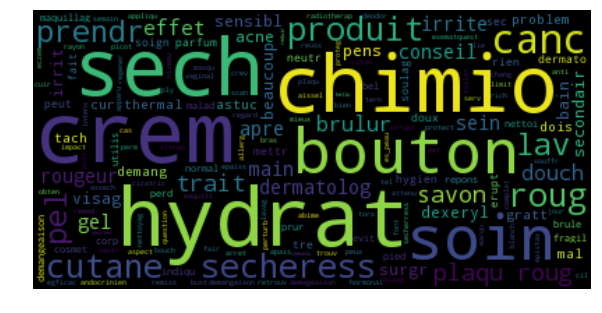

In [106]:
from os import path
from wordcloud import WordCloud

#d = path.dirname()

# Read the whole text.
#text = open(path.join(d, 'constitution.txt')).read()
text = open("C:\Users\emma\Documents\ecole\insa\projet chabot\Intent.csv").read()  
# Generate a word cloud image
wordcloud = WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
#import matplotlib.pyplot as plt
#plt.imshow(wordcloud, interpolation='bilinear')
#plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=60).generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# The pil way (if you don't have matplotlib)
# image = wordcloud.to_image()
# image.show()

In [107]:
# tri par catégorie, on a un data frame pour une catégorie
df = meta_df_clean['Question'][meta_df_clean['Intent'] == '#6-90_TRTEINS_Mauvais_Gout']
description2 = df
description2.to_csv('Intent.csv', sep = ';')

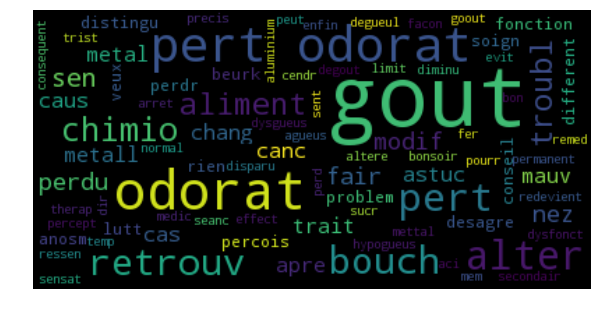

In [108]:
from os import path
from wordcloud import WordCloud

#d = path.dirname()

# Read the whole text.
#text = open(path.join(d, 'constitution.txt')).read()
text = open("C:\Users\emma\Documents\ecole\insa\projet chabot\Intent.csv").read()  
# Generate a word cloud image
wordcloud = WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
#import matplotlib.pyplot as plt
#plt.imshow(wordcloud, interpolation='bilinear')
#plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=60).generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# The pil way (if you don't have matplotlib)
# image = wordcloud.to_image()
# image.show()

In [109]:
# tri par catégorie, on a un data frame pour une catégorie
df = meta_df_clean['Question'][meta_df_clean['Intent'] == '#6-96_TRTEINS_Perte_Poids']
description2 = df
description2.to_csv('Intent.csv', sep = ';')

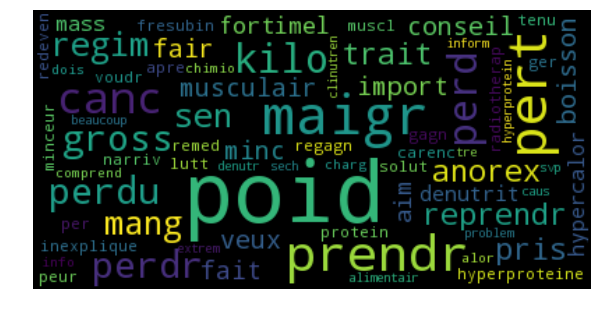

In [110]:
from os import path
from wordcloud import WordCloud

#d = path.dirname()

# Read the whole text.
#text = open(path.join(d, 'constitution.txt')).read()
text = open("C:\Users\emma\Documents\ecole\insa\projet chabot\Intent.csv").read()  
# Generate a word cloud image
wordcloud = WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
#import matplotlib.pyplot as plt
#plt.imshow(wordcloud, interpolation='bilinear')
#plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=60).generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# The pil way (if you don't have matplotlib)
# image = wordcloud.to_image()
# image.show()

In [114]:
meta_df11=meta_df1[meta_df1[0]==1.0]
stopwords_perso = ["ami", "traitement", "patient"]

In [115]:
## Fonction de setmming permettant la racinisation
stemmer=nltk.stem.SnowballStemmer('french')
stopwords2 = list(set(stopwords).union(set(stopwords_perso)))

# Fonction clean générale
def clean_txt2(txt):
    ### remove html stuff
    txt = BeautifulSoup(txt,"html.parser",from_encoding='utf-8').get_text() #nettoyage donnee html
    ### lower case
    txt = txt.lower()
    ### special escaping character '...'
    txt = txt.replace(u'\u2026','.')
    txt = txt.replace(u'\u00a0',' ')
    ### remove accent btw
    txt = unicodedata.normalize('NFD', txt).encode('ascii', 'ignore')
    ###txt = unidecode(txt)
    ### remove non alphanumeric char
    txt = re.sub('[^a-z_]', ' ', txt)
    ### remove french stop words
    tokens = [w for w in txt.split() if (len(w)>2) and (w not in stopwords2)]
    ### french stemming
    tokens = [stemmer.stem(token) for token in tokens]
    #Stemmers remove morphological affixes from words, leaving only the word stem
    ### tokens = stemmer.stemWords(tokens)
    stopwords3=[stemmer.stem(stop) for stop in stopwords2]
    #Stemmers remove morphological affixes from words, leaving only the word stem
    ### tokens = stemmer.stemWords(tokens)
    tokens= [w for w in tokens if (len(w)>2) and (w not in stopwords3)]
    return ' '.join(tokens)
    #join() returns a string in which the string elements of sequence have been joined by str separator.

    # fonction de nettoyage du fichier(stemming et liste de mots à supprimer)
def clean_df2(input_data, column_names= ['Question','Intent','BlockId', 'Action']):
    #Test if columns entry match columns names of input data
    column_names_diff= set(column_names).difference(set(input_data.columns))
    #set.difference   new set with elements in column_names but not in input_data.columns
    
    if column_names_diff: #rentre dans la boucle si column_names différent zero
        # warning = exception
        warnings.warn("Column(s) '"+", ".join(list(column_names_diff)) +"' do(es) not match columns of input data", Warning)
        
    nb_line = input_data.shape[0]
    print("Start Clean %d lines" %nb_line)
    
    # Cleaning start for each columns
    time_start = time.time()
    clean_list=[]
    for column_name in column_names:
        column = input_data[column_name].values
        if column_name == "Question":
            array_clean = np.array(map(clean_txt2,column))
            
        elif column_name == "Intent":
            array_clean = np.asarray(input_data['Intent']) #on recopie telle quelle la colonne intent  
            
        else:
            array_clean = np.array(map(clean_marque,column))
            #applies a function to all the items in an input_list
            #map(function_to_apply, list_of_inputs)
        clean_list.append(array_clean)
    time_end = time.time()
    print("Cleaning time: %d secondes"%(time_end-time_start))
    
    #Convert list to DataFrame
    array_clean = np.array(clean_list).T
    data_clean = pd.DataFrame(array_clean, columns = column_names)
    return data_clean

 
meta_df_clean=clean_df2(meta_df11)

Start Clean 71 lines
Cleaning time: 3 secondes


In [116]:
# tri par catégorie, on a un data frame pour une catégorie
df = meta_df_clean['Question'][meta_df_clean['Intent'] == '#1-5_Menu_Aidant']
description2 = df
description2.to_csv('Intent.csv', sep = ';')

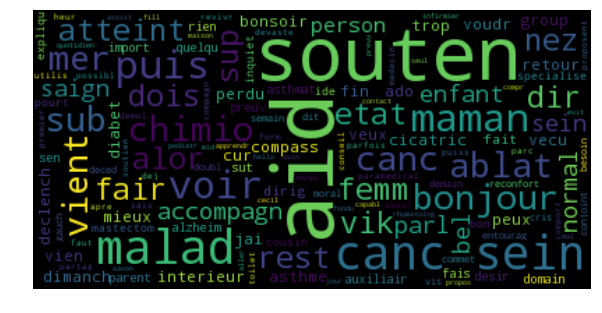

In [117]:
from os import path
from wordcloud import WordCloud

#d = path.dirname()

# Read the whole text.
#text = open(path.join(d, 'constitution.txt')).read()
text = open("C:\Users\emma\Documents\ecole\insa\projet chabot\Intent.csv").read()  
# Generate a word cloud image
wordcloud = WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
#import matplotlib.pyplot as plt
#plt.imshow(wordcloud, interpolation='bilinear')
#plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=60).generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# The pil way (if you don't have matplotlib)
# image = wordcloud.to_image()
# image.show()

In [118]:
# tri par catégorie, on a un data frame pour une catégorie
df = meta_df_clean['Question'][meta_df_clean['Intent'] == '#1-8_Menu_Traitement']
description2 = df
description2.to_csv('Intent.csv', sep = ';')

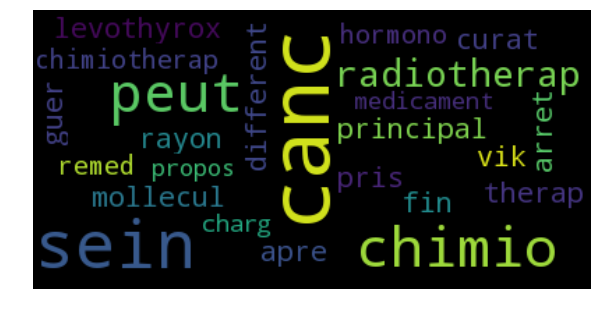

In [119]:
from os import path
from wordcloud import WordCloud

#d = path.dirname()

# Read the whole text.
#text = open(path.join(d, 'constitution.txt')).read()
text = open("C:\Users\emma\Documents\ecole\insa\projet chabot\Intent.csv").read()  
# Generate a word cloud image
wordcloud = WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
#import matplotlib.pyplot as plt
#plt.imshow(wordcloud, interpolation='bilinear')
#plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=60).generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# The pil way (if you don't have matplotlib)
# image = wordcloud.to_image()
# image.show()